# Train

データセットを結合して、学習します。

Jetson Orin Nanoでは、2000枚のデータセットでも1時間程度で学習はおわります。Jetson Nanoでは、2000枚のデータセットの学習には10時間程度かかります。Jetson Nanoユーザは、300枚を超える学習時は、下記URLから起動できるColabを試してください。

https://colab.research.google.com/drive/1GbDrNiosTKSJNOJiCiVgv6V8X-0GDBfW?usp=sharing

Desktop板は、OSXの学習結果はJetRacerにうまく反映できない場合があるようです(GPUの違いで各種Float等の扱いの差分等が原因)

## Workspace指定

In [37]:
import os

# WORKSPACEは、環境に合わせて書き直す!173090
WORKSPACE = None # <- 環境に合わせて修正してください。Noneを指定すると、Currentフォルダを参照

if WORKSPACE == None:
    current_path = os.getcwd()
else:
    current_path = WORKSPACE

## Datasetを指定

DATA_SETSの配列は、自分の作成したデータ設定名に修正します。

In [46]:
#DATA_SETS = ["./dataset/straight_102/","./dataset/straight_110/"]
DATA_SETS = ["./dataset/straight/","./dataset/common/","./dataset/left/"]

In [47]:
import torch
import torchvision
import time
from xy_dataset import XYDataset
import torchvision.transforms as transforms

def load_data(path=''):
    global dataset
    CATEGORIES = ['xy','speed']
    TRANSFORMS = transforms.Compose([
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = XYDataset(path, CATEGORIES, TRANSFORMS, random_hflip=True)
    print(f'データを{len(dataset)} 件読み込みました')
    return dataset

In [48]:
all_datasets = []
for dataset_path in DATA_SETS:
    dataset = load_data(dataset_path)
    all_datasets.append(dataset)

データを52 件読み込みました
データを658 件読み込みました
データを74 件読み込みました


In [49]:
# デバイスの選択
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
def pretrained_model():
    # ALEXNET
    # model = torchvision.models.alexnet(pretrained=True)
    # model.classifier[-1] = torch.nn.Linear(4096, output_dim)

    # SQUEEZENET
    # model = torchvision.models.squeezenet1_1(pretrained=True)
    # model.classifier[1] = torch.nn.Conv2d(512, output_dim, kernel_size=1)
    # model.num_classes = len(dataset.categories)

    # RESNET 18
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(512, output_dim)

    # RESNET 34
    # model = torchvision.models.resnet34(pretrained=True)
    # model.fc = torch.nn.Linear(512, output_dim)

    # DENSENET 121
    # model = torchvision.models.densenet121(pretrained=True)
    # model.classifier = torch.nn.Linear(model.classifier.in_features, output_dim)

    return model

def weights_model():
    # ALEXNET
    # model = torchvision.models.alexnet(weights=torchvision.models.AlexNet_Weights.DEFAULT)
    # model.classifier[-1] = torch.nn.Linear(4096, output_dim)

    # SQUEEZENET
    # model = torchvision.models.squeezenet1_1(weights=torchvision.models.SqueezeNet1_1_Weights.DEFAULT)
    # model.classifier[1] = torch.nn.Conv2d(512, output_dim, kernel_size=1)
    # model.num_classes = len(dataset.categories)

    # RESNET 18
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
    model.fc = torch.nn.Linear(512, output_dim)

    # RESNET 34
    # model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
    # model.fc = torch.nn.Linear(512, output_dim)

    # DENSENET 121
    # model = torchvision.models.densenet121(weights=torchvision.models.DenseNet121_Weights.DEFAULT)
    # model.classifier = torch.nn.Linear(model.classifier.in_features, output_dim)

    return model

def load_trained_mode():
    global model
    
    version_str = torchvision.__version__
    match = re.match(r'(\d+)\.(\d+)\.(\d+)', version_str)
    if match:
        major, minor, _ = map(int, match.groups())
        # 0.13以上の場合
        if major > 0 or minor >= 13:
            # RESNET 18
            model = torchvision.models.resnet18(weights=None)  # pretrained=Falseの代わり
            model.fc = torch.nn.Linear(model.fc.in_features, output_dim)
        else:
            model = torchvision.models.resnet18(pretrained=False)
            model.fc = torch.nn.Linear(512, output_dim)
    
def load_pretrained_model():
    global model
    print('Pre-trainedモデルを読み込みます。')
    # torchvisionのバージョン文字列を取得
    version_str = torchvision.__version__

    # 正規表現でメジャー、マイナー、パッチのバージョンを抜き出す
    match = re.match(r'(\d+)\.(\d+)\.(\d+)', version_str)
    if match:
        major, minor, _ = map(int, match.groups())
        # 0.13以上の場合
        if major > 0 or minor >= 13:
            # pretrainedが非推奨となったため、最新の学習済みwightsを使う
            # https://pytorch.org/blog/introducing-torchvision-new-multi-weight-support-api/
            model = weights_model()
        else:
            # pretrainedを使う
            model = pretrained_model()
    else:
        print("Unable to parse torchvision version")

def load_model(model_file):
    global model, optimizer, output_dim
    # 前提：datasetを読み込み済み
    output_dim = 2 * len(dataset.categories)  # x, y coordinate for each category

    # 学習済みの重みがあれば読み込みます
    if os.path.exists(model_file):
        print(f'重み情報{model_file}を読み込みます。')
        load_trained_mode()
        model = model.to(device)
        model.load_state_dict(torch.load(model_file))
    else:
        # PreTraingのモデルを読み込みます
        load_pretrained_model()
        model = model.to(device)
    
    model = model.eval()

    optimizer = torch.optim.Adam(model.parameters())

def save_model(model_file):
    # ディレクトリが存在しない場合は作成
    os.makedirs(os.path.dirname(model_file), exist_ok=True)
    
    # 学習済みの重みを.pthファイルに保存します。(モデル構造は含みません)
    torch.save(model.state_dict(), model_file)
    print("学習結果を" + model_file + "に保存しました。")

In [50]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import torch.utils.data as data
import time
import os
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader, ConcatDataset, Subset

In [51]:
# 初期の最良の損失値を無限大として設定
best_test_loss = float('inf')
best_train_loss = float('inf')
# 学習と評価の損失の履歴
train_losses = []
test_losses = []
# エポックの履歴
epochs = []

def filter_none(data):
    return [(images, category_idx, xy) for images, category_idx, xy in data if images is not None and xy is not None and category_idx is not None]

def train_eval(is_training=True, batch_size=8, epoch=20, stop_count=10):
    global model, optimizer, best_test_loss, best_train_loss

    # Define current_path
    current_path = os.getcwd()

    # Define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_datasets = []
    for dataset_path in DATA_SETS:
        dataset = load_data(dataset_path)
        all_datasets.append(dataset)

    # Concatenate all datasets
    full_dataset = ConcatDataset(all_datasets)
    print(f'All datasets concatenated. Total data: {len(full_dataset)}')

    # Filter out invalid data
    valid_data = []
    for i in range(len(full_dataset)):
        try:
            _ = full_dataset[i]
            valid_data.append(full_dataset[i])
        except AttributeError as e:
            print(f"Invalid data detected (Index: {i}): {e}")

    full_dataset = valid_data

    # Remove None data
    full_dataset = filter_none(full_dataset)

    # Compute data sizes
    total_size = len(full_dataset)
    split_size = total_size * 10 // 100  # 10% for test data

    # Split indices for train and test
    indices = list(range(total_size))
    train_indices, test_indices = indices[split_size:], indices[:split_size]
    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters())

    model = model.train()
    non_improving_epochs = 0
    epoch_count = 0

    try:
        while epoch > 0:
            sum_train_loss = 0.0

            # Plot losses
            clear_output(wait=True)
            plt.plot(epochs, train_losses, label='Train Loss')
            plt.plot(epochs, test_losses, label='Test Loss')
            plt.title(f"Train Loss ({total_size - split_size} data) vs Test Loss ({split_size} data)")
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.show()

            # Time measurement
            start_time = time.time()

            # Progress bar for training
            progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch_count + 1}")

            for i, (images, category_idx, xy) in progress_bar:
                if images is None or xy is None:
                    print("Warning: None type data found at index", i)
                    continue

                images = images.to(device)
                xy = xy.to(device)

                optimizer.zero_grad()

                outputs = model(images)
                loss = 0.0
                for batch_idx, cat_idx in enumerate(list(category_idx.flatten())):
                    loss += torch.mean((outputs[batch_idx][2 * cat_idx:2 * cat_idx+2] - xy[batch_idx])**2)
                loss /= len(category_idx)
                loss.backward()
                optimizer.step()
                sum_train_loss += float(loss)

                # Update progress bar
                average_loss = sum_train_loss / (i + 1)
                progress_bar.set_description(f"Epoch {epoch_count + 1} Loss: {average_loss:.5f}")

            # Calculate average train loss
            train_loss = sum_train_loss / len(train_loader)
            train_losses.append(train_loss)

            # Evaluate on test data
            model = model.eval()
            sum_test_loss = 0.0
            with torch.no_grad():
                for i, (images, category_idx, xy) in enumerate(test_loader):
                    if images is None or xy is None:
                        print("Error: None type data found at index", i)
                        continue

                    images = images.to(device)
                    xy = xy.to(device)
                    outputs = model(images)
                    loss = 0.0
                    for batch_idx, cat_idx in enumerate(list(category_idx.flatten())):
                        loss += torch.mean((outputs[batch_idx][2 * cat_idx:2 * cat_idx+2] - xy[batch_idx])**2)
                    loss /= len(category_idx)
                    sum_test_loss += float(loss)

            # Calculate average test loss
            test_loss = sum_test_loss / len(test_loader)
            test_losses.append(test_loss)

            # Check for improvement
            best_model = False
            if split_size > 100:
                if test_loss < best_test_loss:
                    best_test_loss = test_loss
                    non_improving_epochs = 0

                    # Save best model
                    path = os.path.join(current_path, "model", "train_best_model.pth")
                    save_model(path)
                    print(f"Saved {path}")
                    print(f"Saved best model with test loss: {best_test_loss}")
                    write_log(f"Saved {path}")
                    best_model = True
                else:
                    non_improving_epochs += 1
            else:
                if train_loss < best_train_loss:
                    best_train_loss = train_loss
                    non_improving_epochs = 0

                    # Save best model
                    path = os.path.join(current_path, "model", "train_best_model.pth")
                    save_model(path)
                    print(f"Saved {path}")
                    print(f"Saved best model with train loss: {best_train_loss}")
                    write_log(f"Saved {path}")
                    best_model = True
                else:
                    non_improving_epochs += 1

            # Update epochs
            epoch -= 1
            epoch_count += 1
            epochs.append(epoch_count)

            # Switch back to training mode
            model = model.train()

            end_time = time.time()
            epoch_duration = end_time - start_time
            total_time = epoch_count * epoch_duration

            # Log training status
            write_log(f"Epoch {epoch_count}: Train Loss: {train_loss:.5f}, Test Loss: {test_loss:.5f}, Best Model: {best_model}, Time: {epoch_duration/60:.2f} min, Total time: {total_time/60:.2f} min")

            if non_improving_epochs >= stop_count:
                print(f"Loss hasn't improved for {non_improving_epochs} consecutive epochs. Stopping training.")
                break

    except Exception as e:
        print(f"Error: {e}")

In [52]:
from IPython.display import display
from ipywidgets import Button, Layout, Textarea,VBox  # Textareaをインポート

l = Layout(flex='0 1 auto', height='100px', min_height='100px', width='auto')
process_widget = Textarea(description='ログ', value='', layout=l)  # 修正: ipywidgetsを削除

process_no = 0
def write_log(msg):
    global process_widget, process_no
    process_no = process_no + 1
    process_widget.value = str(process_no) + ": " + msg + "\n" + process_widget.value

data_collection_widget = VBox([
    process_widget,
])

display(data_collection_widget)

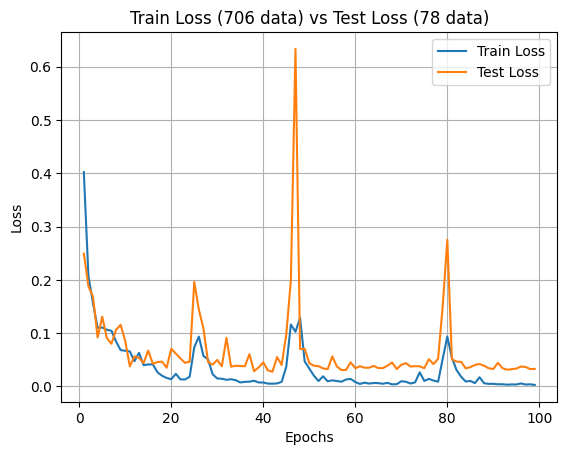

Epoch 100 Loss: 0.00208: 100%|██████████████████| 89/89 [00:02<00:00, 41.88it/s]


学習結果を/home/ubuntu/jetracer/Desktop/notebooks/model/train_best_model.pthに保存しました。
Saved /home/ubuntu/jetracer/Desktop/notebooks/model/train_best_model.pth
Saved best model with train loss: 0.0020767151400331784


In [53]:
import re

# EPOCS数を指定(50〜70 EPOCH, 理想は100 EPOCH)
EPOCHS = 100

MAX_NON_IMPROVING_EPOCHS = 50
BATCH_SIZE = 8
# 初期の最良の損失値を無限大として設定
best_loss = float('inf')
best_test_loss = float('inf')
best_train_loss = float('inf')

# 学習と評価の損失の履歴
train_losses = []
test_losses = []
# エポックの履歴
epochs = []

load_model("")
# best_model.pthを追加で学習する場合
#load_model("best_model.pth")
train_eval(batch_size=BATCH_SIZE, epoch=EPOCHS, stop_count=MAX_NON_IMPROVING_EPOCHS)

## 動画の作成

In [ ]:
import ipywidgets
from ipywidgets import Button, Layout, Textarea, HBox, VBox, Label
import os
import glob

l = Layout(flex='0 1 auto', height='100px', min_height='100px', width='auto')
process_widget = ipywidgets.Textarea(description='ログ', value='', layout=l)

process_no = 0
def write_log(msg):
    global process_widget, process_no
    process_no = process_no + 1
    process_widget.value = str(process_no) + ": " + msg + "\n" + process_widget.value

In [ ]:
LOAD_TASK = ['camera']
IMG_WIDTH = 224
IMG_HEIGHT = 224
SKIP = [1,2,3,4,5]

load_datasets_widget = ipywidgets.Dropdown(options=[], description='dataset')
load_task_widget = ipywidgets.Dropdown(options=LOAD_TASK, description='task')
movie_button = ipywidgets.Button(description='動画の作成')
movie_name_widget = ipywidgets.Text(description='動画名',value="run_video_train")
movie_skip_dropdown = ipywidgets.Dropdown(options=SKIP, description='skip(枚)', index=1)

def change_load_task(change):
    global current_path

    try:
        path = os.path.join(current_path,load_task_widget.value)
        write_log(f"{path}")
        files = os.listdir(path)
        dirs = [f for f in files if os.path.isdir(os.path.join(path, f))]
        dirs = [f for f in files if f != ".ipynb_checkpoints"]
        dirs = sorted(dirs)
        load_datasets_widget.options = dirs
    except:
        write_log(path + "が存在していません。")
        load_datasets_widget.options = []
load_task_widget.observe(change_load_task)
change_load_task(LOAD_TASK[0])

In [ ]:
import cv2
import glob
from utils import preprocess
import re
import torch.nn.functional as F
import time

load_model("./model/train_best_model.pth")

def extract_numbers(filename):
    matches = re.findall(r'(\d+)', filename)
    if matches and len(matches) >= 3: 
        return int(matches[-1])  
    else:
        return float('inf')

def get_file_names(path):
    file_names = os.listdir(path)
    file_names = [os.path.join(path, file_name) for file_name in file_names]
    image_names = []

    image_names = sorted(file_names, key=lambda f: extract_numbers(os.path.basename(f)))
    image_names = [f for f in image_names if os.path.splitext(f)[1].lower() == ".jpg"]
    
    return image_names

def make_movie(change):
    global model,current_path
    
    if not movie_name_widget.value.strip():
        write_log("ファイル名を指定してください。")
        return 
    write_log("動画を作成します。")
    
    path = os.path.join("./", "video/")
    #if not os.path.exists(path):
    #    subprocess.call(['mkdir', '-p', path])
    output = path + movie_name_widget.value + ".mp4"
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = int(30 / movie_skip_dropdown.value)
    outfh = cv2.VideoWriter(output, fourcc, fps, (224, 224))
    write_log(f"{load_task_widget.value}")
    write_log(f"{load_datasets_widget.value}")
    file_list = sorted(
        glob.glob(load_task_widget.value + '/' + load_datasets_widget.value + '/xy/*.jpg'),
        key=os.path.getmtime
    )
    
    xy_path = os.path.join(current_path, load_task_widget.value, load_datasets_widget.value, "xy")     
    write_log(f"{xy_path}")
    file_list = os.listdir(xy_path)
    
    file_list = [os.path.join(xy_path, file_name) for file_name in file_list if file_name.endswith('.jpg')]    
    file_list = sorted(file_list, key=lambda f: extract_numbers(os.path.basename(f)))
    
    
    try:
        res_num = len(file_list)
        
        count = 0
        skip_movie = movie_skip_dropdown.value
        terminal_time = 1/(30/skip_movie)
        current_time = 0
        process_time = 0
        total_process_time = 0
        for i, file_name in enumerate(file_list):
            
            if i % skip_movie == 0:
                current_time += terminal_time
                img = cv2.imread(file_name)
                
                process_time = time.time()
                preprocessed = preprocess(img)
                output = model(preprocessed).detach().cpu().numpy().flatten()
                result_x = float(output[0])
                result_y = float(output[1])
                result_x = int(IMG_WIDTH * (result_x / 2.0 + 0.5))
                result_y = int(IMG_HEIGHT * (result_y / 2.0 + 0.5))    
                img = cv2.circle(img, (int(result_x), int(result_y)), 8, (255, 0, 0), 3)

                # Speed
                result_speed = output[3]
                result_speed = int(IMG_WIDTH * (result_speed / 2.0 + 0.5))
                if result_speed > 224:
                    result_speed = 244
                elif result_speed < 0:
                    result_speed = 0
                img = cv2.line(img,(218,0),(218,224),(0,0,0),5)
                img = cv2.line(img,(219,224-result_speed),(219,224),(0,140,255),3)
                img = cv2.putText(img,"speed:"+str(result_speed),(160,215),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,255,255))
                total_process_time += time.time() - process_time 
                
                if i % (skip_movie*10) == 0:
                    write_log(f"{current_time:.1f}秒まで完了, 推論処理平均: {total_process_time/10*1000:.1f}ms, {int(i/skip_movie)}枚目/{int(res_num/skip_movie)}枚中を処理中")
                    total_process_time = 0
                outfh.write(img)
                del img
    finally:
        # エラーが発生しても確実にリソースを解放する
        outfh.release()
        write_log("動画の出力が完了しました。")

movie_button.on_click(make_movie)

In [ ]:
separator = ipywidgets.HTML('<hr style="border-color:gray;margin:10px 0"/>')
title1 = ipywidgets.HTML('<b>【走行動画の作成】</b> 動画ファイル名を指定してください。')

convert_widget = ipywidgets.VBox([
    separator,
    title1,
    ipywidgets.HBox([load_datasets_widget,load_task_widget]),
    ipywidgets.HBox([movie_name_widget,movie_skip_dropdown,movie_button]),
    process_widget,
])
display(convert_widget)